##### Copyright 2024 Google LLC.

In [3]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# How to Fine-tuning Gemma for Spoken Language Tasks

This notebook demonstrate how to fine tune Gemma for the specific task on replying to email requests that a Korean bakery business might get.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Gemma/spoken-language-tasks/k-gemma-it/spoken_language_tasks_with_gemma.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Setup

### Select the Colab runtime
To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the Gemma model:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **L4** or **A100 GPU**.


### Gemma setup on Kaggle
To complete this tutorial, you'll first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

* Get access to Gemma on kaggle.com.
* Select a Colab runtime with sufficient resources to run the Gemma 2B model.
* Generate and configure a Kaggle username and API key.

After you've completed the Gemma setup, move on to the next section, where you'll set environment variables for your Colab environment.

### Set environemnt variables

Set environement variables for ```KAGGLE_USERNAME``` and ```KAGGLE_KEY```.

In [ ]:
import os
from google.colab import userdata, drive

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

# Mounting gDrive for to store artifacts
drive.mount("/content/drive")

### Install dependencies

Install Keras and KerasNLP

In [2]:
!pip install -q -U keras-nlp datasets
!pip install -q -U keras

# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

import keras_nlp
import keras

# Run at half precision.
#keras.config.set_floatx("bfloat16")

# Training Configurations
token_limit = 512
num_data_limit = 100
lora_name = "cakeboss"
lora_rank = 4
lr_value = 1e-4
train_epoch = 20
model_id = "gemma2_instruct_2b_en"

## Load Model

In [3]:
import keras
import keras_nlp

import time

gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

tick_start = 0

def tick():
    global tick_start
    tick_start = time.time()

def tock():
    print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")

def text_gen(prompt):
    tick()
    input = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma_lm.generate(input, max_length=token_limit)
    print("\nGemma output:")
    print(output)
    tock()

# inference before fine-tuning
text_gen("다음에 대한 이메일 답장을 작성해줘.\n\"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?\"")

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)


Gemma output:
<start_of_turn>user
다음에 대한 이메일 답장을 작성해줘.
"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?"<end_of_turn>
<start_of_turn>model
##  답장 예시

**제목: Re: 결혼기념일 케이크 주문 문의**

안녕하세요, [주문자 이름]님,

안녕하세요. 결혼기념일 케이크 주문을 받으셨네요! 😊 

3호 케이크 1개를 주문하시는군요. 

[주문자 이름]님의 결혼기념일을 축하드립니다! 

[케이크 종류, 옵션, 주문 날짜 등]에 대한 자세한 정보를 알려주시면 최대한 멋진 케이크를 만들어 드리겠습니다. 

[주문자 이름]님께서 원하는 케이크의 디자인, 옵션, 주문 날짜 등을 알려주시면 됩니다. 

[주문자 이름]님께서 원하는 케이크를 만들어 드리겠습니다. 

감사합니다.

[이름]
[회사명/전화번호/이메일 주소] 


**참고:**

* 위 답장은 예시이며, 실제 답장에 필요한 내용을 추가하거나 수정해야 할 수 있습니다. 
* 케이크 종류, 옵션, 주문 날짜 등을 명확하게 알려주는 것이 중요합니다. 
* 답장에 친절하고 긍정적인 분위기를 유지하는 것이 좋습니다. 
* 케이크 주문에 대한 추가 질문이 있으면 언제든지 문의해주세요. 



<end_of_turn>
TOTAL TIME ELAPSED: 41.09s


## Load Dataset

In [7]:
import keras
import keras_nlp
import datasets

tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)

# prompt structure
# <start_of_turn>user
# 다음에 대한 이메일 답장을 작성해줘.
# "{EMAIL CONTENT FROM THE CUSTOMER}"
# <end_of_turn>
# <start_of_turn>model
# {MODEL ANSWER}<end_of_turn>

# input, output
from datasets import load_dataset
ds = load_dataset(
    "bebechien/korean_cake_boss",
    split="train",
)
print(ds)
data = ds.with_format("np", columns=["input", "output"], output_all_columns=False)
train = []

for x in data:
  item = f"<start_of_turn>user\n다음에 대한 이메일 답장을 작성해줘.\n\"{x['input']}\"<end_of_turn>\n<start_of_turn>model\n{x['output']}<end_of_turn>"
  length = len(tokenizer(item))
  # skip data if the token length is longer than our limit
  if length < token_limit:
    train.append(item)
    if(len(train)>=num_data_limit):
      break

print(len(train))
print(train[0])
print(train[1])
print(train[2])

README.md:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20 [00:00<?, ? examples/s]

Dataset({
    features: ['input', 'output'],
    num_rows: 20
})
20
<start_of_turn>user
다음에 대한 이메일 답장을 작성해줘.
"안녕하세요,
2주 뒤에 있을 아이 생일을 위해 3호 케이크 3개를 주문하고 싶은데 가능할까요?"<end_of_turn>
<start_of_turn>model
고객님, 안녕하세요.

2주 뒤 아이 생일을 위한 3호 케이크 2개 주문 문의 감사합니다.
네, 3호 케이크 2개 주문 가능합니다.

아이 생일 케이크인 만큼 더욱 신경 써서 정성껏 준비하겠습니다. 혹시 원하시는 디자인이나 특별한 요청 사항이 있으시면 편하게 말씀해주세요.

픽업 날짜와 시간을 알려주시면 더욱 자세한 안내를 도와드리겠습니다.

다시 한번 문의 감사드리며, 아이 생일 진심으로 축하합니다!

[가게 이름] 드림<end_of_turn>
<start_of_turn>user
다음에 대한 이메일 답장을 작성해줘.
"안녕하세요,

9월 15일에 있을 아들의 돌잔치를 위해 케이크를 주문하고 싶습니다.
- 케이크 종류: 생크림 케이크
- 크기: 2호
- 디자인: 아기자기한 동물 디자인
- 문구: "첫 생일 축하해, 사랑하는 아들!"
- 픽업 날짜 및 시간: 9월 14일 오후 3시

가격 및 주문 가능 여부를 알려주시면 감사하겠습니다.

감사합니다.
김민지 드림"<end_of_turn>
<start_of_turn>model
안녕하세요, 김민지 님,

9월 15일 아드님의 돌잔치를 위한 케이크 주문 문의 감사합니다.

- 생크림 케이크 2호, 아기자기한 동물 디자인, "첫 생일 축하해, 사랑하는 아들!" 문구, 9월 14일 오후 3시 픽업 모두 가능합니다.
- 가격은 5만원입니다.

주문을 원하시면 연락 주세요.
감사합니다.

[가게 이름] 드림<end_of_turn>
<start_of_turn>user
다음에 대한 이메일 답장을 작성해줘.
"안녕하세요, 박지혜라고 합니다.

10월 5일에 있을 결혼 10주년 기념일

## LoRA Fine-tuning

In [8]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=lora_rank)
gemma_lm.summary()

# Limit the input sequence length (to control memory usage).
gemma_lm.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

Note that enabling LoRA reduces the number of trainable parameters significantly.

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 1.1019 - sparse_categorical_accuracy: 0.5969
Gemma output:
<start_of_turn>user
다음에 대한 이메일 답장을 작성해줘.
"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?"<end_of_turn>
<start_of_turn>model
##  답장 예시

**제목: Re: 결혼기념일 케이크 주문 문의**

안녕하세요, [주문자 이름]님,

안녕하세요. 결혼기념일 케이크 주문을 받으셨네요! 😊 

3호 케이크 1개를 주문하시면, 멋진 결혼기념일을 축하드립니다! 

[주문 내용에 대한 추가 정보를 적어주세요. 예시: 케이크 종류, 크기, 디자인, 주문 날짜, 배송 지역 등]

[주문 가능 여부에 대한 답변]

* 케이크 주문이 가능합니다. 
* [케이크 주문 가능 여부에 대한 추가 설명]

[케이크 주문 시 추가 정보를 요청할 수 있는 문구]

* [예시: 케이크 디자인에 대한 추가 설명, 배송 날짜, 배송 지역 등]

[주문에 대한 답변을 위한 추가 문구]

* [예시: 케이크 주문이 완료되었는지 확인해주세요.]

감사합니다. 

[이름]

[회사/개인 정보]


**참고:**

* 위 답변은 예시이며, 실제 답변에 따라 내용을 수정해야 합니다. 
* 케이크 주문에 대한 추가 정보를 적어주세요. 
* 답변에 대한 질문이 있으면 언제든지 문의해주세요. 



<end_of_turn>
TOTAL TIME ELAPSED: 39.27s
10/10 ━━━━━━━━━━━━━━━━━━━━ 128s 8s/step - loss: 1.1012 - sparse_categorical_accuracy: 0.5964
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - loss: 1.0636 - sparse_categorical_accuracy: 0.6019


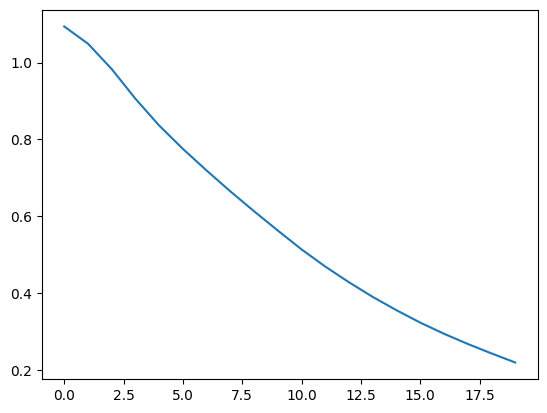

In [9]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    model_name = f"/content/drive/MyDrive/{lora_name}_{lora_rank}_epoch{epoch+1}.lora.h5"
    gemma_lm.backbone.save_lora_weights(model_name)

    # Evaluate
    text_gen("다음에 대한 이메일 답장을 작성해줘.\n\"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?\"")

history = gemma_lm.fit(train, epochs=train_epoch, batch_size=2, callbacks=[CustomCallback()])

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()

In [4]:
# Example Code for Load LoRA
'''
train_epoch=17
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
# Use the same LoRA rank that you trained
gemma_lm.backbone.enable_lora(rank=4)

# Load pre-trained LoRA weights
gemma_lm.backbone.load_lora_weights(f"/content/drive/MyDrive/{lora_name}_{lora_rank}_epoch{train_epoch}.lora.h5")
'''

## Try a different sampler

The top-K algorithm randomly picks the next token from the tokens of top K probability.

In [8]:
gemma_lm.compile(sampler="top_k")
text_gen("다음에 대한 이메일 답장을 작성해줘.\n\"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?\"")
text_gen("다음에 대한 이메일 답장을 작성해줘.\n\"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?\"")
text_gen("다음에 대한 이메일 답장을 작성해줘.\n\"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?\"")


Gemma output:
<start_of_turn>user
다음에 대한 이메일 답장을 작성해줘.
"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?"<end_of_turn>
<start_of_turn>model
고객님, 안녕하세요.

결혼기념일 3호 케이크 주문 가능합니다! 3호 케이크는 다양한 종류의 맛과 장식이 가능합니다. 원하시는 맛과 장식을 알려주시면 맞춤으로 디자인해 드리겠습니다.

주문 날짜, 시간, 필요한 픽업 날짜 등 추가적인 문의를 말씀해주세요.

감사합니다.

[가게 이름] 드림<end_of_turn>
TOTAL TIME ELAPSED: 5.88s

Gemma output:
<start_of_turn>user
다음에 대한 이메일 답장을 작성해줘.
"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?"<end_of_turn>
<start_of_turn>model
안녕하세요.,

결혼기념일 3호 케이크 주문 가능합니다! 케이크 맛과 디자인에 대해 문의해주시면 맞춤 제작을 도와드리겠습니다. 혹시 특별히 원하시는 맛이나 디자인이 있으신가요?

감사합니다.

[가장점 케이크 문의 담당자 이름] 드림<end_of_turn>
TOTAL TIME ELAPSED: 4.75s

Gemma output:
<start_of_turn>user
다음에 대한 이메일 답장을 작성해줘.
"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?"<end_of_turn>
<start_of_turn>model
안녕하세요,

결혼기념일 3호 케이크 주문 가능합니다! 3호 케이크 1개를 주문하시려면, 픽업 날짜와 시간, 원하신 디자인 (혹은 사진)을 말씀해주세요.

감사합니다.

[가게 이름] 드림<end_of_turn>
TOTAL TIME ELAPSED: 3.98s


Try a slight different prompts

In [6]:
text_gen("다음에 대한 답장을 작성해줘.\n\"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?\"")
text_gen("아래에 적절한 답장을 써줘.\n\"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?\"")
text_gen("다음에 관한 답장을 써주세요.\n\"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?\"")


Gemma output:
<start_of_turn>user
다음에 대한 답장을 작성해줘.
"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?"<end_of_turn>
<start_of_turn>model
 안녕하세요. 결혼기념일 3호 케이크 1개 주문 가능합니다. 원하시는 디자인이나 특별사항이 있으시면 말씀해주세요. 감사합니다. 😊<end_of_turn>
TOTAL TIME ELAPSED: 2.69s

Gemma output:
<start_of_turn>user
아래에 적절한 답장을 써줘.
"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?"<end_of_turn>
<start_of_turn>model
안녕하세요. 결혼기념일을 위한 3호 케이크 주문 가능합니다! 3호 케이크는 [가격]이며, 디자인은 다양하게 선택 가능합니다. 원하신 디자인과 함께 주문하시면 감사하겠습니다. 궁금한 점 있으시면 언제든지 문의해주세요. 😊 
<end_of_turn>
TOTAL TIME ELAPSED: 4.41s

Gemma output:
<start_of_turn>user
다음에 관한 답장을 써주세요.
"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?"<end_of_turn>
<start_of_turn>model
안녕하세요.,

3호 케이크 1개 주문 가능합니다. 결혼기념일을 위한 특별한 케이크로 궁금하신 건, 정말 축하드립니다! 

주문하실 때 필요한 정보를 알려주시면 더욱 맞춤화해 드리려고 합니다. 예시로, 케이크 디자인, 크기, 문구, 픽업 날짜/시간 등을 말씀해주시면 됩니다.

감사합니다.

[가게 이름] 드림<end_of_turn>
TOTAL TIME ELAPSED: 6.30s


Try a different email inputs

In [7]:
text_gen("""다음에 대한 이메일 답장을 작성해줘.
"안녕하세요,

6월 15일에 있을 행사 답례품으로 쿠키 & 머핀 세트를 대량 주문하고 싶습니다.

수량: 50세트
구성: 쿠키 2개 + 머핀 1개 (개별 포장)
디자인: 심플하고 고급스러운 디자인 (리본 포장 등)
문구: "감사합니다" 스티커 부착
배송 날짜: 6월 14일
대량 주문 할인 혜택이 있는지, 있다면 견적과 함께 배송 가능 여부를 알려주시면 감사하겠습니다.

감사합니다.

박철수 드림" """)



Gemma output:
<start_of_turn>user
다음에 대한 이메일 답장을 작성해줘.
"안녕하세요,

6월 15일에 있을 행사 답례품으로 쿠키 & 머핀 세트를 대량 주문하고 싶습니다.

수량: 50세트
구성: 쿠키 2개 + 머핀 1개 (개별 포장)
디자인: 심플하고 고급스러운 디자인 (리본 포장 등)
문구: "감사합니다" 스티커 부착
배송 날짜: 6월 14일
대량 주문 할인 혜택이 있는지, 있다면 견적과 함께 배송 가능 여부를 알려주시면 감사하겠습니다.

감사합니다.

박철수 드림" <end_of_turn>
<start_of_turn>model
박철수 님, 안녕하세요.

6월 15일 행사 답례품 주문 문의 감사합니다.

- 50 세트 대량 주문 가능합니다.
- 쿠키 2개 + 머핀 1개 (개별 포장) 디자인, "감사합니다" 스티커 부착
- 6월 14일 배송 가능합니다.
- 대량 주문 시 10% 할인 혜택 제공됩니다.

견적 및 배송 가능 여부를 원하시면 곧 전화해주세요.

감사합니다.

[가게 이름] 드림<end_of_turn>
TOTAL TIME ELAPSED: 7.54s
